## Modeling (core)
#### New notebook to create LTE models. Based off of all_spectra_and_models.py and related files.
Last edited 8/17/22.

In [1]:
# For parallelization, which helps to make convolution faster
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
from dask.diagnostics import ProgressBar
ProgressBar().register()
import warnings
warnings.filterwarnings('ignore')

### 1. Get our data cubes from files

In [2]:
from astropy import units as u

results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

In [3]:
# Get names of spectral windows, copied from the "Spectral Lines in The Brick" Google Sheet
freq_spws = [
'87_spw25',
'89_spw27',
'91_spw25', 
'93_spw27',
'95_spw25', 
'97_spw27',
'98_spw29',
'99_spw31',
'102_spw23',
'102_spw29',
'103_spw31',
'106_spw29',
'107_spw31',
'110_spw29',
'111_spw31',
'112_spw27',
'114_spw29',
'127_spw65', 
'129_spw67',
'130_spw105',
'132_spw107',
'134_spw45', 
'135_spw47',
'137_spw85',
'137_spw69', 
'139_spw71',
'140_spw109',
'142_spw111',
'144_spw49',
'146_spw51',
'147_spw89',
'149_spw91',
'142_spw27',  # mislabeled
'152_spw31',
'244_spw65',
'245_spw67',
'247_spw105',
'249_spw107',
'250_spw25',
'252_spw27',
'254_spw85',
'255_spw87',
'257_spw45',
'258_spw69',
'259_spw47',
'259_spw71',
'261_spw109',
'263_spw111',
'264_spw29',
'266_spw31',
'268_spw89',
'270_spw91',
'271_spw49',
'273_spw51'
]

In [4]:
# Only look at one cube from here on out
ind = freq_spws.index('146_spw51')

In [5]:
from spectral_cube import SpectralCube

cube = SpectralCube.read(results+'source_ab_'+freq_spws[ind]+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True)

### 2. Convert cube to a common beam

Skipping converting all cubes to a common beam because I only want to examine one spectrum at a time.

In [6]:
cube_common_beam = cube.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
smoothed_cube = cube.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular

# import radio_beam

# beams = []
# for cube in smoothed_cubes:
#     beams.append(cube.beam)

# common_beam = radio_beam.commonbeam.common_manybeams_mve(radio_beam.Beams(beams = beams)) # Get common beam between all cubes
# common_beam

In [7]:
# resampled_cubes = []
# for cube in smoothed_cubes:
#     resampled_cube = cube.convolve_to(common_beam) # This cell takes almost no time; the cubes do not get convolved in this step
#     resampled_cubes.append(resampled_cube)

### 3. Extract spectrum and plot our data

In [8]:
# Extract spectrum for a coordinate in central core region
from astropy import coordinates
from astropy import wcs

crd = coordinates.SkyCoord("17:46:10.63 -28:42:17.8", frame='fk5', unit=(u.h, u.deg))

x, y = map(int, smoothed_cube.wcs.celestial.world_to_pixel(crd))

In [9]:
# m0 = smoothed_cube.moment0()
# m0 = smoothed_cube[0] # HACK to make go faster

In [10]:
import matplotlib.pyplot as plt

SM_SIZE = 12
MD_SIZE = 18
LG_SIZE = 22

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

In [11]:
# # Why am I plotting this?
# ax = plt.subplot(projection = m0.wcs)
# plt.plot(x, y, marker = 'x', color = 'r')
# im = ax.imshow(m0.value, origin='lower', cmap='inferno')
# cbar = plt.colorbar(im)
# cbar.set_label(f'Integrated Intensity [{m0.unit}]')
# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

In [12]:
spectrum = smoothed_cube[:, y, x].to(u.K)

[########################################] | 100% Completed | 319.35 s
[########################################] | 100% Completed | 315.52 s


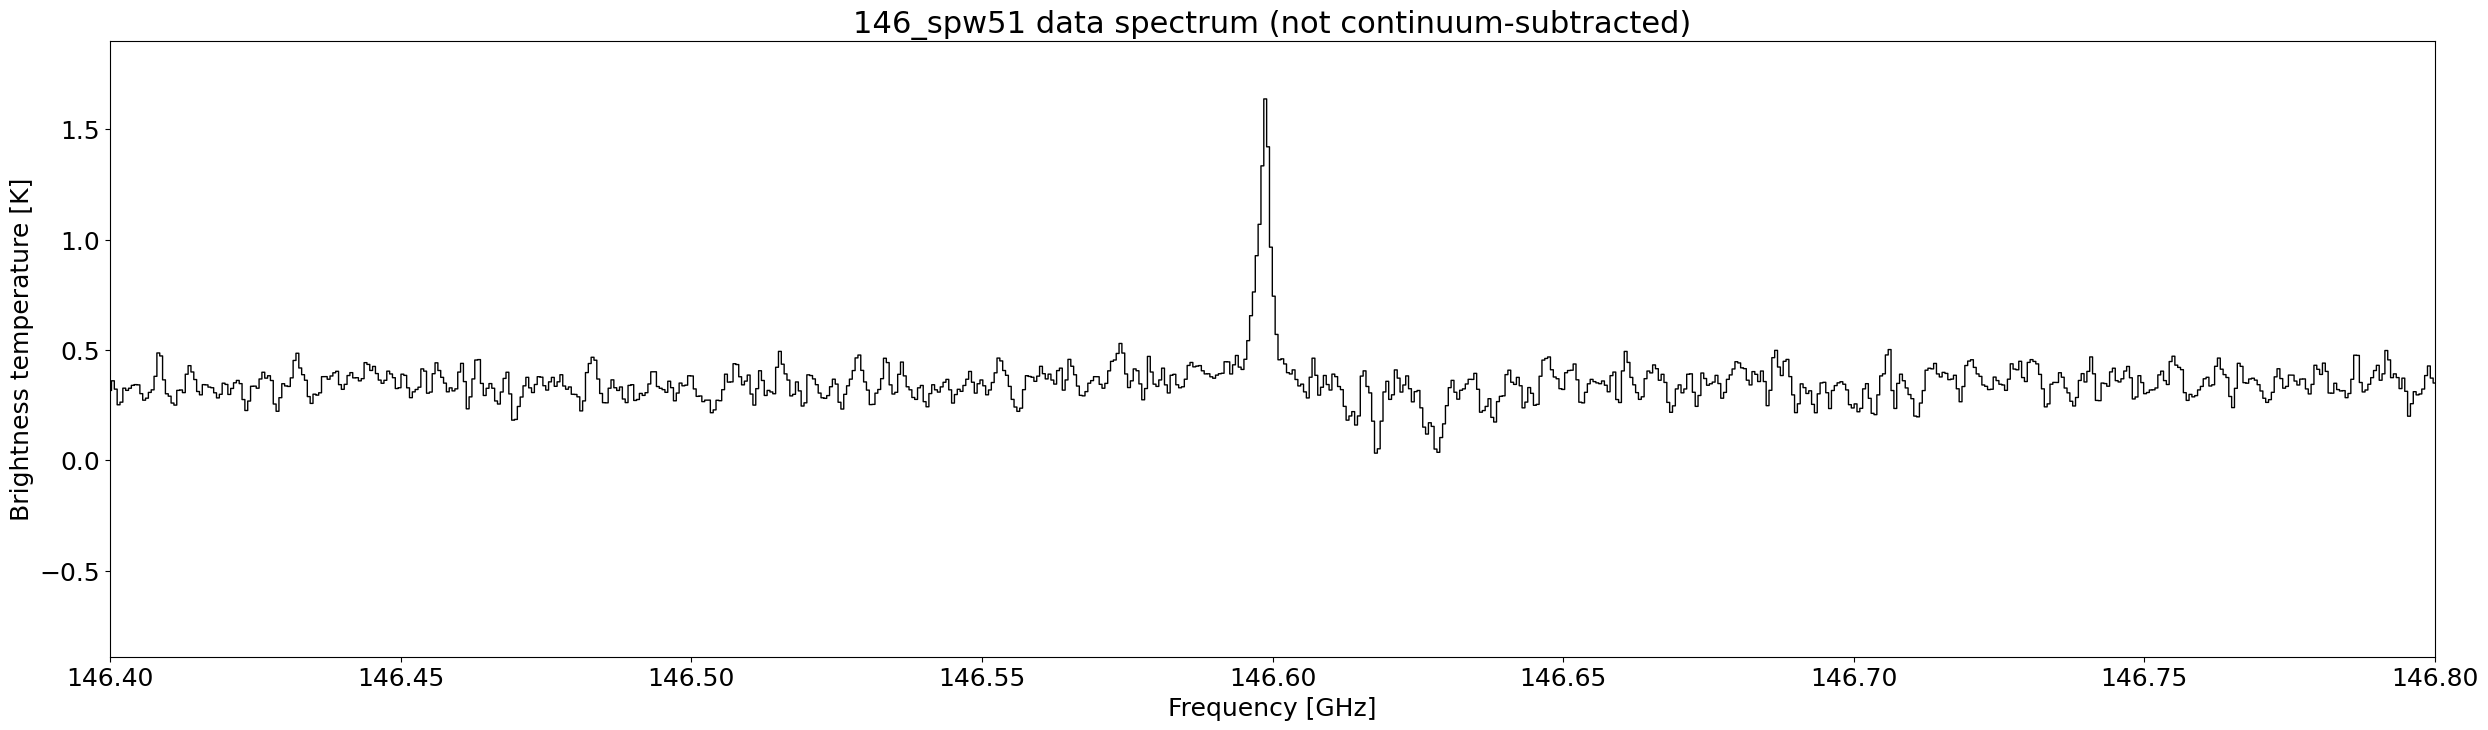

In [13]:
import numpy as np

fig = plt.figure(figsize = (30, 8))

plt.plot(smoothed_cube.spectral_axis.to(u.GHz), np.array(spectrum), linestyle = '-', color = 'k', linewidth = 1, drawstyle = 'steps-mid')
plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
# plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
plt.xlim(146.4, 146.8)
plt.title(f"{freq_spws[ind]} data spectrum (not continuum-subtracted)")
plt.show()

### 4. Generate molfit files for each molecule of interest

In [14]:
# Get molecule names
import sqlite3
conn = sqlite3.connect('/orange/adamginsburg/software/XCLASS-Interface/Database/cdms_sqlite.db')
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT T_Name FROM Transitions")
molecules = cursor.fetchall()
molecules_ = [x[0] for x in molecules]
any('CH2NH' in x for x in molecules_) # Check for a molecule
[x[0] for x in molecules if 'HCN' in x[0]] # List all listings for a molecule

KeyboardInterrupt: 

In [ ]:
cmap = plt.get_cmap('tab20') # Can use cmap(0) through (cmap19) to access

In [ ]:
# User-maintained molecule list (includes colors, linestyles, and column densities)
# Colors should cycle like this: tab:blue, tab:orange, tab:green, tab:red, tab:purple, tab:pink, tab:olive, tab:cyan
# Linestyles: --, -., :, (0,(3,1,1,1,1,1))
default = 1
default_Ntot = 5e13

molecules = {'(CH3)2CO;v=0;': [cmap(0),  '--', default_Ntot], # XCLASS does not have?
             'c-HCCCH;v=0;' : [cmap(1),  '--', default_Ntot],
             'CCCS;v=0;'    : [cmap(2),  '--', default_Ntot],
             'CCH;v=0;'     : [cmap(3),  '--', default_Ntot],
             'CCS;v=0;'     : [cmap(4),  '--', default_Ntot],
             'C2H5OH;v=0;'  : [cmap(5),  '--', default_Ntot],
             'C3H2;v=0;'    : [cmap(6),  '--', default_Ntot],
             'CH2NH;v=0;'   : [cmap(7),  '--', default_Ntot],
             'CH3CN;v=0;'   : [cmap(8),  '--', 5e13],
             'CH3C-13-N;v=0;' : [cmap(9),  '--', default_Ntot], # Corrected for XCLASS
             'CH3CCH;v=0;'  : [cmap(10),  '--', default_Ntot],
             'CH3CHO;v=0;'  : [cmap(11),  '--', default_Ntot],
             'CH3CHO;v=1;'  : [cmap(12),  '--', default_Ntot],
             'CH3CHO;v=2;'  : [cmap(13),  '--', default_Ntot],
             'CH3OCHO;v=0;' : [cmap(14),  '--', 1e14],
             'CH3OCH3;v=0;' : [cmap(15),  '--', default_Ntot],
             'CH3OH;v=0;'   : [cmap(16),  '--', 1e15], 
             'CH3OH;v=1;'   : [cmap(17),  '--', default_Ntot],
             'CH3OH;v=2;'   : [cmap(18),  '--', default_Ntot],
             '13CH3OH;v=0;' : [cmap(19),  '--', default_Ntot],
             'CH3NH2;v=0;'  : [cmap(0),  '--', default_Ntot],
             'CO;v=0;'      : [cmap(1),  '-.', 1e18], 
             '13CO;v=0;'    : [cmap(2),  '-.', 1e17], 
             'C17O;v=0;'    : [cmap(3),  '-.', default_Ntot], 
             'C18O;v=0;'    : [cmap(4),  '-.', default_Ntot], 
             'CS;v=0;'      : [cmap(5),  '-.', default_Ntot],
             '13CS;v=0;'    : [cmap(6),  '-.', default_Ntot],
             'C34S;v=0;'    : [cmap(7),  '-.', default_Ntot],
             'CN;v=0;'      : [cmap(8),  '-.', default_Ntot],
             '13CN;v=0;'    : [cmap(9),  '-.', default_Ntot],
             'H2CS;v=0;'    : [cmap(10),  '-.', default_Ntot], 
             'H213CS;v=0;'  : [cmap(11),  '-.', default_Ntot],
             'H2CO;v=0;'    : [cmap(12),  '-.', 1e16],
             'HC3N;v=0;'    : [cmap(13),  '-.', default_Ntot],
             'H13CCCN;v=0;' : [cmap(14),  '-.', default_Ntot],
             'HCN;v=0;'     : [cmap(15),  '-.', default_Ntot],
             'H13CN;v=0;'   : [cmap(16),  '-.', default_Ntot],
             'HC15N;v=0;'   : [cmap(17),  '-.', default_Ntot],
             'DCN;v=0;'     : [cmap(18),  '-.', default_Ntot],
             'HCO+;v=0;'    : [cmap(19),  '-.', default_Ntot],
             'H13CO+;v=0;'  : [cmap(0),  '-.', default_Ntot],
             'HDCO;v=0;'    : [cmap(1),  ':',  default_Ntot], 
             'HNCO;v=0;'    : [cmap(2),  ':',  default_Ntot], 
             'HNC;v=0;'     : [cmap(3),  ':',  default_Ntot], 
             'HN13C;v=0;'   : [cmap(4),  ':',  default_Ntot], 
             'HOCO+;v=0;'   : [cmap(5),  ':',  default_Ntot], 
             'N2H+;v=0;'    : [cmap(6),  ':',  default_Ntot], 
             'NH2CHO;v=0;'  : [cmap(7),  ':',  default_Ntot], 
             'NH2CN;v=0;'   : [cmap(8),  ':',  default_Ntot],
             'NH2D;v=0;'    : [cmap(9),  ':',  default_Ntot], 
             'NH3;v=0;'     : [cmap(10),  ':',  default_Ntot], 
             'NS;v=0;'      : [cmap(11),  ':',  default_Ntot],
             'OCS;v=0;'     : [cmap(12),  ':',  default_Ntot], 
             'O13CS;v=0'    : [cmap(13),  ':',  default_Ntot],
             'SiO;v=0;'     : [cmap(14),  ':',  default_Ntot],
             '29SiO;v=0;'   : [cmap(15),  ':',  default_Ntot],
             'SiO;v=1;'     : [cmap(16),  ':',  default_Ntot],
             'SO;v=0;'      : [cmap(17),  ':',  default_Ntot],
             'SO2;v=0;'     : [cmap(18),  ':',  default_Ntot]
            }

In [ ]:
###### LOOP OVER MOLECULES IN THAT TABLE, GRAB NAME TO PLACE IN THE NAME PART, AND TO USE AS FILENAME, AND ALSO GRAB COLUMN DENSITY
import os
import sys

# Define path and name of molfit file
LocalPath = os.getcwd() + "/"

##### MAKE SURE THIS IS THE LAYOUT I SHOULD BE USING; I THINK IT'S NOT--need ranges?

def set_xclass_parameters(mol_name, source_size, tkin, Ntot, vwidth_fwhm, filename): # Removed vcen
    with open(filename, "w") as fh:
        fh.write(f"""
%%MinNumTransitionsSQL = 1
%%MaxNumTransitionsSQL = 0
%%MaxElowSQL = 1000000.0
%%MingASQL = 0.0
%%OrderTransSQL = 1
%            source size:  T_kin:  N_tot:  V_width:      V_off:   CFFlag:
%            [arcsec]:     [K]:    [cm-2]: [km /s]:      [km /s]: []:
{mol_name} 1 
             {source_size} {tkin}  {Ntot}  {vwidth_fwhm} 20       c
{mol_name} 1 
             {source_size} {tkin}  {Ntot}  {vwidth_fwhm} 50       c
""")

for mol in molecules:
    fn = LocalPath + "molfit_files/" + mol.replace(';','').replace('(','').replace(')','').replace('=','').replace('+','p') + ".molfit"
    Ntot = molecules[mol][2]
    set_xclass_parameters(mol_name = mol, source_size = 0.33, tkin = 150, Ntot = Ntot, vwidth_fwhm = 5, filename = fn)
### CAN INCLUDE MULTIPLE TEMPERATURE AND VELOCITY COMPONENTS, EVENTUALLY

### 5. Generate XCLASS model of the same spectral window for separate molecules

In [ ]:
# Get path of XCLASS directory
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"

# Extend sys.path variable
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)

import task_myXCLASS

In [ ]:
# define freq. step (in MHz)
FreqStep = 0.1

# define beam minor axis length (in arsec)
BMIN = smoothed_cube.beam.minor.to(u.arcsec).value # None

# define beam major axis length (in arsec)
BMAJ = smoothed_cube.beam.major.to(u.arcsec).value # None

# define beam position angle (in degree)
BPA = smoothed_cube.beam.pa.to(u.deg).value # None

# depending on parameter "Inter_Flag" define beam size (in arcsec)
# (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
TelescopeSize = np.abs(BMIN**2 - BMAJ**2)**0.5 # arcsec # 1000.0 # meters

# interferometric data?
Inter_Flag = True

# define red shift
Redshift = None

# BACKGROUND: describe continuum with tBack and tslope only
t_back_flag = True

# BACKGROUND: define background temperature (in K)
tBack = 0.0

# BACKGROUND: define temperature slope (dimensionless)
tslope = 0.0

# BACKGROUND: define path and name of ASCII file describing continuum as function
#             of frequency
BackgroundFileName = ""

# DUST: define hydrogen column density (in cm^(-2))
N_H = 1.e22

# DUST: define spectral index for dust (dimensionless)
beta_dust = 0.0

# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
kappa_1300 = 0.0

# DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
DustFileName = ""

# FREE-FREE: define electronic temperature (in K)
Te_ff = None

# FREE-FREE: define emission measure (in pc cm^(-6))
EM_ff = None

# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
kappa_sync = None

# SYNCHROTRON: define magnetic field (in Gauss)
B_sync = None

# SYNCHROTRON: energy spectral index (dimensionless)
p_sync = None

# SYNCHROTRON: thickness of slab (in AU)
l_sync = None

# PHEN-CONT: define phenomenological function which is used to describe
#            the continuum
ContPhenFuncID = None

# PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam1 = None

# PHEN-CONT: define second parameter for phenomenological function
ContPhenFuncParam2 = None

# PHEN-CONT: define third parameter for phenomenological function
ContPhenFuncParam3 = None

# PHEN-CONT: define fourth parameter for phenomenological function
ContPhenFuncParam4 = None

# PHEN-CONT: define fifth parameter for phenomenological function
ContPhenFuncParam5 = None

# use iso ratio file?
iso_flag = True

# define path and name of iso ratio file
#DEFAULT IsoTableFileName = LocalPath + "files/my_isonames.txt"
IsoTableFileName = LocalPath + "my_isonames.txt"

# define path and name of file describing Non-LTE parameters
CollisionFileName = ""

# define number of pixels in x-direction (used for sub-beam description)
NumModelPixelXX = 100

# define number of pixels in y-direction (used for sub-beam description)
NumModelPixelYY = 100

# take local-overlap into account or not
LocalOverlapFlag = False

# disable sub-beam description
NoSubBeamFlag = True

# define path and name of database file
dbFilename = ""

# define rest freq. (in MHz)
RestFreq = 0.0

# define v_lsr (in km/s)
vLSR = 0.0

In [ ]:
import io
from contextlib import redirect_stdout

def myxclass_call(FreqMin=1e3, FreqMax=1e4, verbose=False):
    ## call myXCLASS function
    with io.StringIO() as buf, redirect_stdout(buf):
        modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                    FreqMin, FreqMax, FreqStep,
                                                    TelescopeSize, BMIN, BMAJ,
                                                    BPA, Inter_Flag, Redshift,
                                                    t_back_flag, tBack, tslope,
                                                    BackgroundFileName,
                                                    N_H, beta_dust, kappa_1300,
                                                    DustFileName, Te_ff, EM_ff,
                                                    kappa_sync, B_sync, p_sync,
                                                    l_sync, ContPhenFuncID,
                                                    ContPhenFuncParam1,
                                                    ContPhenFuncParam2,
                                                    ContPhenFuncParam3,
                                                    ContPhenFuncParam4,
                                                    ContPhenFuncParam5,
                                                    MolfitsFileName, iso_flag,
                                                    IsoTableFileName,
                                                    CollisionFileName,
                                                    NumModelPixelXX,
                                                    NumModelPixelYY,
                                                    LocalOverlapFlag,
                                                    NoSubBeamFlag,
                                                    dbFilename,
                                                    RestFreq, vLSR)
        output = buf.getvalue()
    if verbose:
        print(output)
        
    return modeldata, log, TransEnergies, IntOpt, JobDir

In [ ]:
# define min. freq. (in MHz)
FreqMin = np.min(spectrum.spectral_axis.to(u.MHz)).value
# define max. freq. (in MHz)
FreqMax = np.max(spectrum.spectral_axis.to(u.MHz)).value

In [ ]:
import glob
MolfitsFileNames = glob.glob(LocalPath + 'molfit_files/*.molfit')

modeldata_all = []
transenergies_all = []
for MolfitsFileName in MolfitsFileNames:
    print(MolfitsFileName)
    modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
    modeldata_all.append(modeldata)
    transenergies_all.append(TransEnergies)

In [ ]:
from astropy.stats import mad_std

# Preliminary continuum subtraction
spectrum_contsub = np.array(spectrum) - np.median(np.array(spectrum))

# Get MAD-estimated RMS of data spectrum
mad_rms = mad_std(spectrum_contsub)

In [ ]:
fig = plt.figure(figsize = (30, 8))

plt.plot(smoothed_cube.spectral_axis.to(u.GHz), spectrum_contsub, linestyle = '-', color = 'grey', linewidth = 1, drawstyle = 'steps-mid', 
        label = "Data")
plt.axhspan(ymin = -mad_rms, ymax = mad_rms, alpha = 0.25, color = 'k', label = 'RMS level in data')
for index, (modeldata, transenergies) in enumerate(zip(modeldata_all, transenergies_all)):
    molname = 
#     molname = MolfitsFileNames[index].replace('/blue/adamginsburg/abulatek/brick/first_results/modeling/molfit_files/', '').replace('.molfit', '')
    if len(modeldata) != 0:
        colorname = transenergies[1][-1]
        plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], color = molecules[colorname][0], linestyle = molecules[colorname][1], linewidth = 1, 
                 drawstyle = 'steps-mid', label = molname.replace('p','+').replace('v0',' v=0')
    else:
        print(f"***** Warning! {molname} was not modeled! *****")
plt.legend(loc = 'best')
plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
# plt.xlim(137.25, 137.50)
plt.title(f"{freq_spws[ind]} data and model comparison")
# plt.title(f"{freq_spws[ind]} data and model comparison, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92 # NOTE: TKIN AND NTOT MAY CHANGE WHEN WE FIT !
plt.savefig(f"spectra/{freq_spws[ind]}.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight') # dpi = 300
plt.show()